In [27]:
import pdfplumber
import re

def debug_pdf_text(pdf_path):
    """
    This function opens a PDF and prints the text from the page
    containing "FORM NL-4" to help diagnose extraction issues.
    """
    print(f"--- Debugging Text from: {pdf_path} ---")
    try:
        with pdfplumber.open(pdf_path) as pdf:
            found_page = False
            for i, page in enumerate(pdf.pages):
                # Using a tighter tolerance can sometimes help with layout
                text = page.extract_text(x_tolerance=2, y_tolerance=2) or ""
                
                # Find the page with the relevant header
                if "FORM NL-4" in text.upper() and "PREMIUM SCHEDULE" in text.upper():
                    print(f"\n*** Found 'FORM NL-4' on Page {i + 1} ***\n")
                    print(text)
                    print("\n--- End of Page Text ---")
                    
                    # Also, let's see what the table extractor gets
                    table = page.extract_table()
                    if table:
                        print("\n*** Extracted Table Data ***\n")
                        for row in table:
                            print(row)
                        print("\n--- End of Table Data ---")
                    else:
                        print("\n*** Could not extract a table from this page. ***")

                    found_page = True
                    break # We only need the first matching page
            
            if not found_page:
                print("\n*** CRITICAL: Could not find a page with 'FORM NL-4' and 'PREMIUM SCHEDULE'. ***")
                # As a fallback, let's print the text from the first page to see the provider name
                if pdf.pages:
                    print("\n--- Printing text from Page 1 as a fallback: ---\n")
                    print(pdf.pages[0].extract_text(x_tolerance=2, y_tolerance=2))
                    
    except Exception as e:
        print(f"An error occurred while processing the PDF: {e}")
        
    print("\n--- End of Debug ---")

# --- PLEASE SET THIS TO A FAILING PDF FILE ---
file_to_debug = "data/Q1 2024.pdf" 
# ---------------------------------------------

debug_pdf_text(file_to_debug)


--- Debugging Text from: data/Q1 2024.pdf ---

*** Found 'FORM NL-4' on Page 4 ***

Aditya Birla Health Insurance Co. Limited
Registration No. 153 and Dated 11 July 2016
FORM NL-4-PREMIUM SCHEDULE
(Amount in Rs. Lakhs)
Health Personal Accident Travel Total Health Personal Accident Travel Total
Particulars
(A) (B) (C) (A + B + C) (A) (B) (C) (A + B + C)
For The Quarter Ended 30th June 2023 For The Period Ended 30th June 2023
Gross Direct Premium 71,231 4,869 1,076 77,176 71,231 4,869 1,076 77,176
Add: Premium on reinsurance accepted - - - - - - - -
Less : Premium on reinsurance ceded 15,813 263 51 16,127 15,813 263 51 16,127
Net Written Premium 55,418 4,606 1,025 61,049 55,418 4,606 1,025 61,049
Add: Opening balance of UPR 99,544 7,437 252 1,07,233 99,544 7,437 252 1,07,233
Less: Closing balance of UPR 1,03,756 7,808 125 1,11,689 1,03,756 7,808 125 1,11,689
Net Earned Premium 51,205 4,236 1,152 56,593 51,205 4,236 1,152 56,593
Gross Direct Premium
- In India 71,231 4,869 1,076 77,176 71

In [1]:
import os
import glob
import pandas as pd
import pdfplumber
import re

In [2]:
# --- 1. SETUP: Define your data and output directories ---
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
OUT_DIR = os.path.join(BASE_DIR, "output")

In [3]:
# --- 2. THE PARSER: The final, corrected function ---
def parse_nl4_table_final(pdf_path):
    """
    Extracts Health, Personal Accident, and Travel premium data from
    a FORM NL-4 PDF schedule. This version robustly finds the premium
    row even with PDF table extraction inconsistencies.
    """
    provider = ""
    month_map = {
        'march': {'quarter': 'Q4', 'fy_offset': 0}, 'mar': {'quarter': 'Q4', 'fy_offset': 0},
        'june': {'quarter': 'Q1', 'fy_offset': 1}, 'jun': {'quarter': 'Q1', 'fy_offset': 1},
        'september': {'quarter': 'Q2', 'fy_offset': 1}, 'sep': {'quarter': 'Q2', 'fy_offset': 1},
        'december': {'quarter': 'Q3', 'fy_offset': 1}, 'dec': {'quarter': 'Q3', 'fy_offset': 1}
    }

    try:
        with pdfplumber.open(pdf_path) as pdf:
            if pdf.pages:
                first_page_text = pdf.pages[0].extract_text(x_tolerance=2) or ""
                for line in first_page_text.splitlines():
                    if "Insurance" in line and ("Ltd" in line or "Limited" in line):
                        m = re.search(r"([A-Za-z &]+Insurance[^,\n]*)", line)
                        if m:
                            provider = m.group(1).strip()
                            break

            for page in pdf.pages:
                text = page.extract_text(x_tolerance=2) or ""
                if "FORM NL-4" in text.upper() and "PREMIUM SCHEDULE" in text.upper():
                    fy, quarter = None, None
                    pat = re.compile(r"For\s+The\s+Quarter\s+Ended\s+\d{1,2}(?:st|nd|rd|th)?\s+([A-Za-z]+)[, ]+\s*(\d{4})", re.IGNORECASE)
                    match = pat.search(text)
                    if match:
                        month_str, year = match.group(1).lower(), int(match.group(2))
                        for key, meta in month_map.items():
                            if month_str.startswith(key[:3]):
                                quarter, fy_year = meta['quarter'], year + meta['fy_offset']
                                fy = f"FY{str(fy_year)[-2:]}"
                                break
                    
                    table = page.extract_table()
                    if not table: continue

                    for row in table:
                        if row and any(cell and re.search(r"Gross\s+Direct\s+Premium", str(cell)) for cell in row):
                            numeric_values = [str(cell).replace(",", "").strip() for cell in row if cell and isinstance(cell, str) and str(cell).replace(",", "").strip().isdigit()]
                            if len(numeric_values) >= 4:
                                h, p, t, tot = [int(x) for x in numeric_values[:4]]
                                result = {
                                    "provider": provider or "Unknown", "quarter": quarter, "fiscal_year": fy,
                                    "health": h, "personal_accident": p, "travel": t, "total": tot
                                }
                                result['source_file'] = os.path.basename(pdf_path)
                                return result
                    break 
    except Exception as e:
        print(f"  -> An error occurred while processing {os.path.basename(pdf_path)}: {e}")
    return None



In [4]:
# --- 3. PROCESSING LOOP: Extract data from all PDFs ---
records = []
failed_files = []

if not os.path.isdir(DATA_DIR):
    print(f"❌ Error: Data directory not found at '{DATA_DIR}'")
else:
    for pdf_file in sorted(glob.glob(os.path.join(DATA_DIR, "*.pdf"))):
        print(f"📄 Processing: {pdf_file}")
        result = parse_nl4_table_final(pdf_file)
        if result:
            print(f"✅ Extracted: {result['provider']}, {result['fiscal_year']} {result['quarter']}")
            records.append(result)
        else:
            print(f"❌ Failed to extract data from: {pdf_file}")
            failed_files.append(pdf_file)

    print(f"\nTotal successfully extracted: {len(records)}")
    print(f"Total failed: {len(failed_files)}")




📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q1 2024.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY24 Q1
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q1 2025.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY25 Q1
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q1 FY 23.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY23 Q1
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q2 2024.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY24 Q2
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q2 2025.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY25 Q2
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q2 FY 23.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY23 Q2
📄 Processing: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\data\Q3 2024.pdf
✅ Extracted: Aditya Birla Health Insurance Co. Limited, FY24 Q3
📄 Pr

In [5]:
# --- 4. DATAFRAME CREATION AND SAVING (WITH YOUR CHANGES) ---
if records:
    df = pd.DataFrame(records)
    
    # --- MODIFICATION BLOCK START ---
    
    # 1. Rename the 'fiscal_year' column to 'year'
    df.rename(columns={'fiscal_year': 'year'}, inplace=True)
    
    # 2. Convert year values from 'FY24' to integer 2024
    if 'year' in df.columns:
        df['year'] = df['year'].apply(lambda fy_str: int(f"20{fy_str[2:]}") if fy_str else None)

    # --- MODIFICATION BLOCK END ---

    # Reorder columns with the new 'year' column
    column_order = [
        'provider', 'year', 'quarter', 
        'health', 'personal_accident', 'travel', 'total', 'source_file'
    ]
    df = df[column_order]

    os.makedirs(OUT_DIR, exist_ok=True)
    out_csv = os.path.join(OUT_DIR, "premium_by_quarter.csv")
    df.to_csv(out_csv, index=False)
    print(f"\n✅ Data successfully saved to CSV: {out_csv}")

    print("\n--- DataFrame Preview ---")
    print(df.head())
else:
    print("\nNo data was extracted, so no file was saved.")


✅ Data successfully saved to CSV: c:\Users\saifi\GitHub\InsurancePremiumAnalyzer\output\premium_by_quarter.csv

--- DataFrame Preview ---
                                    provider  year quarter  health  \
0  Aditya Birla Health Insurance Co. Limited  2024      Q1   71231   
1  Aditya Birla Health Insurance Co. Limited  2025      Q1   96804   
2  Aditya Birla Health Insurance Co. Limited  2023      Q1   56992   
3  Aditya Birla Health Insurance Co. Limited  2024      Q2   73826   
4  Aditya Birla Health Insurance Co. Limited  2025      Q2  104814   

   personal_accident  travel   total   source_file  
0               4869    1076   77176   Q1 2024.pdf  
1               5664    1591  104059   Q1 2025.pdf  
2               4180    1867   63039  Q1 FY 23.pdf  
3               4222     827   78875   Q2 2024.pdf  
4               6843    1365  113022   Q2 2025.pdf  


In [7]:
df = pd.read_csv(os.path.join(OUT_DIR, "premium_by_quarter.csv"))
df.head()

,provider,year,quarter,health,personal_accident,travel,total,source_file
0,Aditya Birla Health Insurance Co. Limited,2024,Q1,71231,4869,1076,77176,Q1 2024.pdf
1,Aditya Birla Health Insurance Co. Limited,2025,Q1,96804,5664,1591,104059,Q1 2025.pdf
2,Aditya Birla Health Insurance Co. Limited,2023,Q1,56992,4180,1867,63039,Q1 FY 23.pdf
3,Aditya Birla Health Insurance Co. Limited,2024,Q2,73826,4222,827,78875,Q2 2024.pdf
4,Aditya Birla Health Insurance Co. Limited,2025,Q2,104814,6843,1365,113022,Q2 2025.pdf


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   provider           12 non-null     object
 1   year               12 non-null     int64 
 2   quarter            12 non-null     object
 3   health             12 non-null     int64 
 4   personal_accident  12 non-null     int64 
 5   travel             12 non-null     int64 
 6   total              12 non-null     int64 
 7   source_file        12 non-null     object
dtypes: int64(5), object(3)
memory usage: 900.0+ bytes


In [10]:
df.describe()

,year,health,personal_accident,travel,total
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2024.000000,86057.500000,6296.583333,1313.083333,93667.083333
std,0.852803,28916.482747,3660.935932,474.789611,30245.775830
min,2023.000000,52953.000000,3705.000000,702.000000,58783.000000
25%,2023.000000,68041.250000,4160.250000,841.250000,73887.500000
50%,2024.000000,78851.000000,5104.000000,1270.500000,84874.500000
75%,2025.000000,98806.500000,7036.750000,1758.000000,106837.500000
max,2025.000000,151441.000000,16955.000000,1970.000000,160314.000000


### Average Premium by Quarter

In [11]:
df.groupby("quarter")[["health", "personal_accident", "travel", "total"]].mean()

,health,personal_accident,travel,total
quarter,,,,
Q1,75009.000000,4904.333333,1511.333333,81424.666667
Q2,79037.333333,4923.333333,1345.666667,85306.333333
Q3,72482.666667,8798.333333,1202.333333,82483.000000
Q4,117701.000000,6560.333333,1193.000000,125454.333333


### Plot Gross Direct Premium Over Time

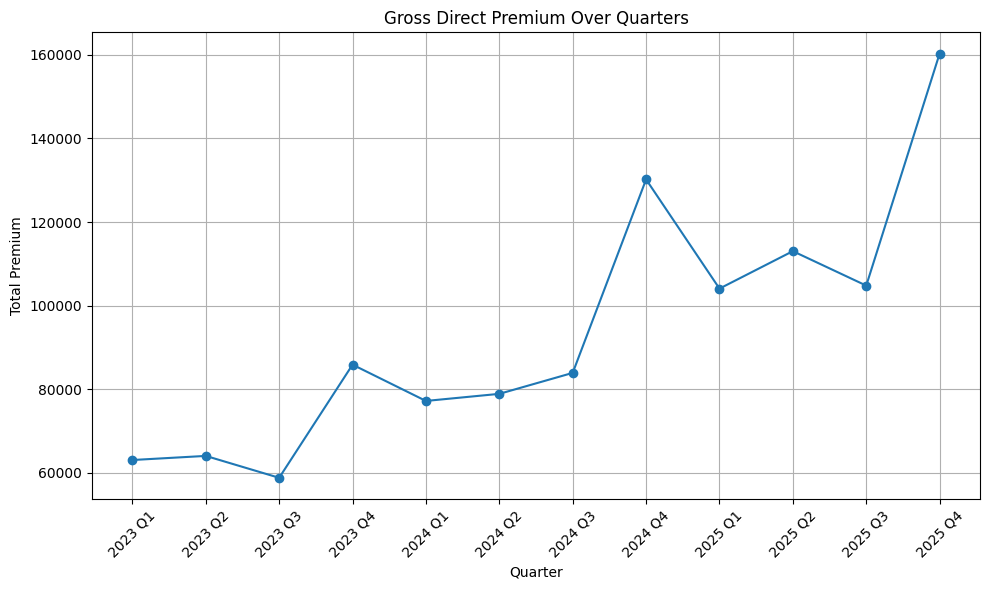

In [8]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by=["year", "quarter"])
df_sorted["label"] = df_sorted["year"].astype(str) + " " + df_sorted["quarter"]

plt.figure(figsize=(10,6))
plt.plot(df_sorted["label"], df_sorted["total"], marker="o", label="Total Premium")
plt.title("Gross Direct Premium Over Quarters")
plt.xlabel("Quarter")
plt.ylabel("Total Premium")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
